# **Waste Material Segregation for Improving Waste Management**

## **Objective**

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

* Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
* Improve waste segregation efficiency to support recycling and reduce landfill waste.
* Understand the properties of different waste materials to optimise sorting methods for sustainability.

## **Data Understanding**

The Dataset consists of images of some common waste materials.

1. Food Waste
2. Metal
3. Paper
4. Plastic
5. Other
6. Cardboard
7. Glass


**Data Description**

* The dataset consists of multiple folders, each representing a specific class, such as `Cardboard`, `Food_Waste`, and `Metal`.
* Within each folder, there are images of objects that belong to that category.
* However, these items are not further subcategorised. <br> For instance, the `Food_Waste` folder may contain images of items like coffee grounds, teabags, and fruit peels, without explicitly stating that they are actually coffee grounds or teabags.

## **1. Load the data**

Load and unzip the dataset zip file.

**Import Necessary Libraries**

In [200]:
# Recommended versions:

# numpy version: 1.26.4
# pandas version: 2.2.2
# seaborn version: 0.13.2
# matplotlib version: 3.10.0
# PIL version: 11.1.0
# tensorflow version: 2.18.0
# keras version: 3.8.0
# sklearn version: 1.6.1

In [374]:
# Import essential libraries
import os
import re
import scipy
import shutil
import random
import visualkeras

import numpy as np
import pandas as pd
import zipfile as zf
import seaborn as sns
import matplotlib.pyplot as plt

from keras.utils import to_categorical
from torchvision import transforms as T
from torchvision.datasets import ImageFolder

from PIL import Image
from pathlib import Path

import fastai
from fastai.vision.all import *
from fastai.vision.augment import aug_transforms

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from keras.layers import Flatten
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

In [202]:
import warnings
warnings.filterwarnings("ignore")

In [360]:
#setting display option
pd.set_option("display.max_columns",300)
pd.set_option('display.max_rows',300)

Load the dataset.

In [205]:
data=zf.ZipFile('data.zip','r')
data.extractall()
data.close()

## **2. Data Preparation** <font color=red> [25 marks] </font><br>


### **2.1 Load and Preprocess Images** <font color=red> [8 marks] </font><br>

Let us create a function to load the images first. We can then directly use this function while loading images of the different categories to load and crop them in a single step.

#### **2.1.1** <font color=red> [3 marks] </font><br>
Create a function to load the images.

In [210]:
# Create a function to load the raw images
data_dir=Path('data')
transformer=T.Compose([T.Resize((32,32)),T.ToTensor()])
dataset=ImageFolder(data_dir,transform=transformer)
print(dataset.classes)

['Cardboard', 'Food_Waste', 'Glass', 'Metal', 'Other', 'Paper', 'Plastic']


#### **2.1.2** <font color=red> [5 marks] </font><br>
Load images and labels.

Load the images from the dataset directory. Labels of images are present in the subdirectories.

Verify if the images and labels are loaded correctly.

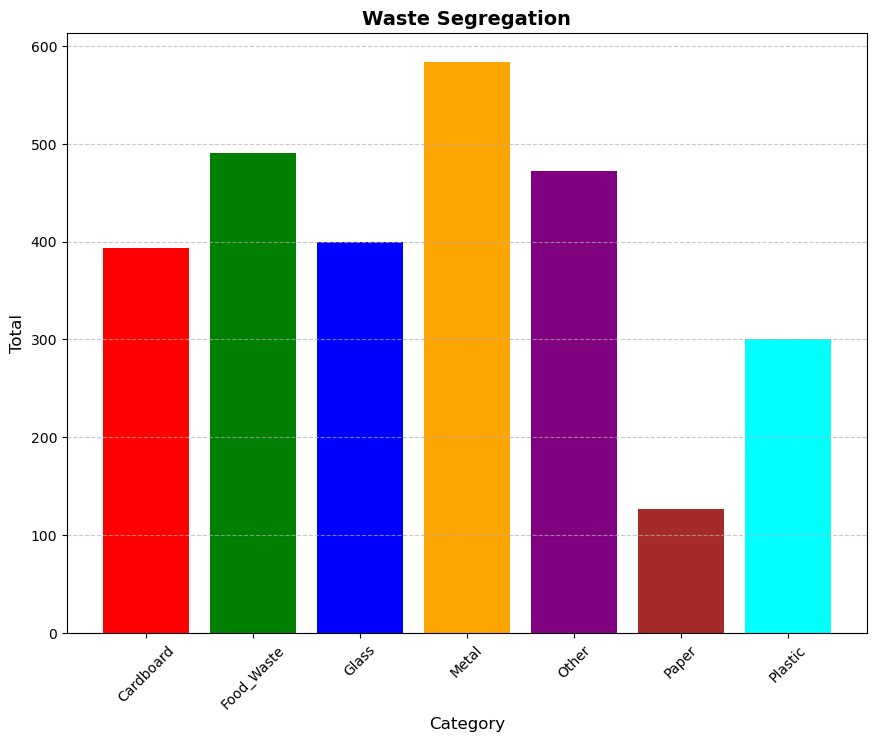

In [213]:
#data and the plot
fig=plt.figure(figsize=(8,6))
ax=fig.add_axes([0, 0, 1, 1])
counts=[393,491,400,584,472,127,300]
labels=dataset.classes
colors=['red','green','blue','orange','purple','brown','cyan']
ax.bar(labels,counts,color=colors)
plt.title('Waste Segregation',fontsize=14,fontweight='bold')
plt.xlabel('Category',fontsize=12)
plt.ylabel('Total',fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y',linestyle='--',alpha=0.7)
plt.tight_layout()
plt.show()

image array and label arrays

iterate over data directory and find out the labels
        label_dir = os.path.basename(os.path.dirname(filepath))
        iterate over files present in label_dir    
         you will read that file
         load_imag     

Perform any operations, if needed, on the images and labels to get them into the desired format.

### **2.2 Data Visualisation** <font color=red> [9 marks] </font><br>

#### **2.2.1** <font color=red> [3 marks] </font><br>
Create a bar plot to display the class distribution

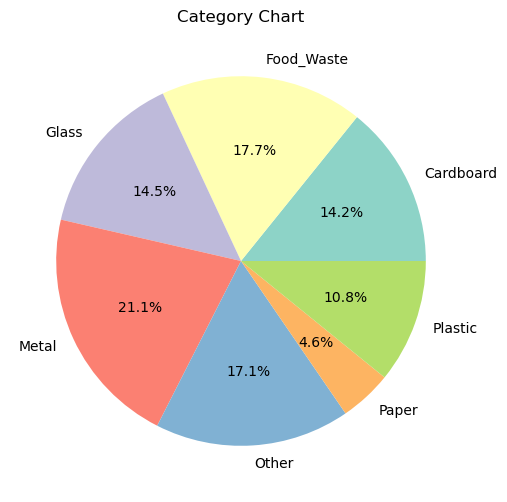

In [218]:
# Visualise Data Distribution
plt.figure(figsize=(6,6))
plt.pie(counts,labels=labels,autopct='%1.1f%%',colors=plt.cm.Set3.colors)
plt.title('Category Chart')
plt.show()

#### **2.2.2** <font color=red> [3 marks] </font><br>
Visualise some sample images

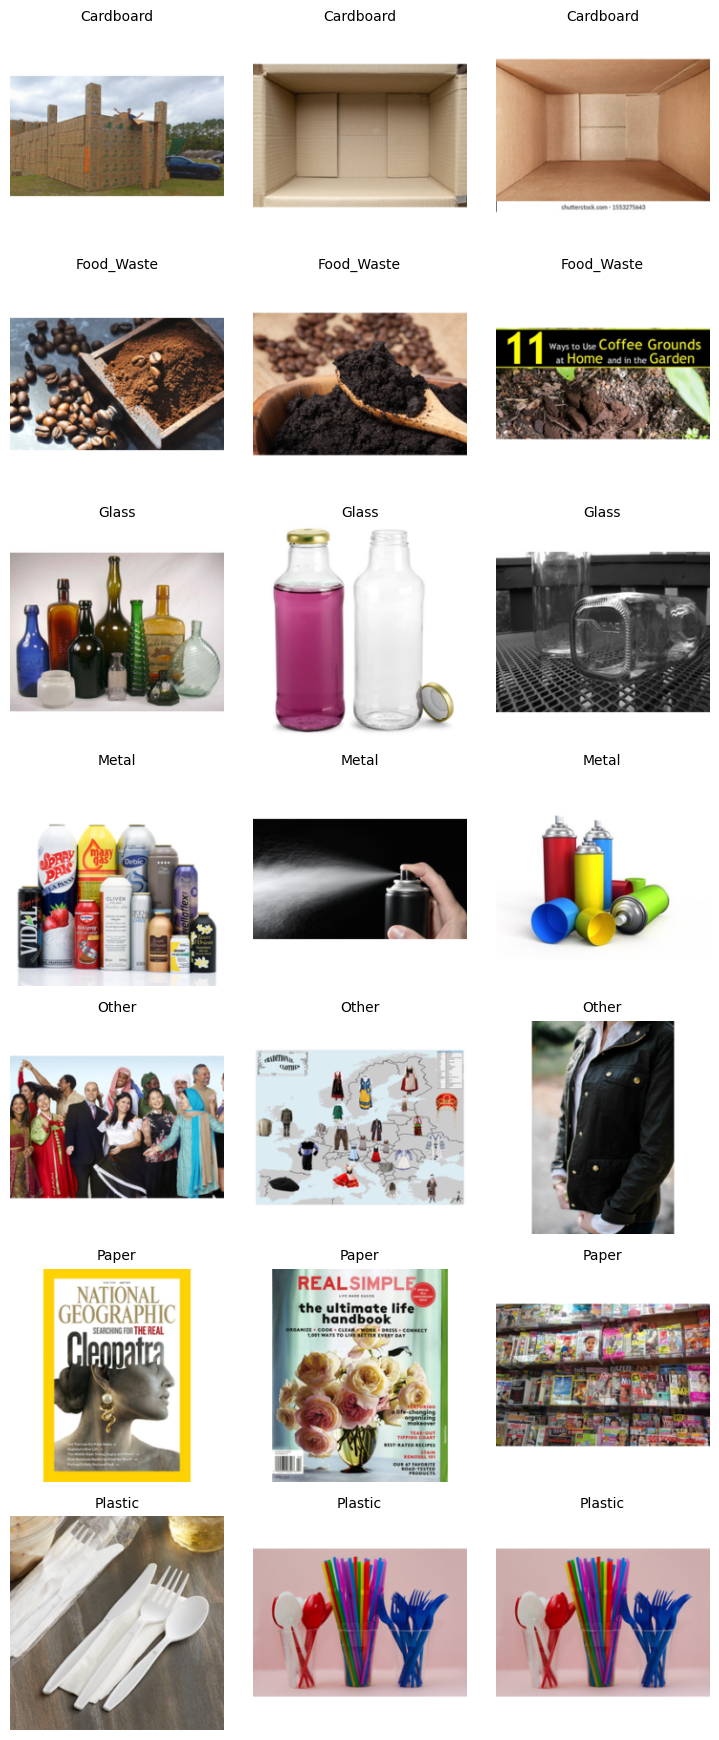

In [362]:
# Visualise Sample Images (across different labels)
#sample images from each category
data_dir=Path('data')
transformer=T.Compose([T.Resize((224, 224)),T.ToTensor()])
dataset=ImageFolder(data_dir, transform=transformer)
class_names=dataset.classes
samples_per_class=3
images_by_class={class_idx:[] for class_idx in range(len(class_names))}

for img,label in dataset:
    if len(images_by_class[label])<samples_per_class:
        images_by_class[label].append(img)
    if all(len(imgs)==samples_per_class for imgs in images_by_class.values()):
        break

fig,axs=plt.subplots(len(class_names),samples_per_class,figsize=(samples_per_class*2.5,len(class_names)*2.5))

for class_idx,imgs in images_by_class.items():
    for j in range(samples_per_class):
        ax=axs[class_idx,j] if len(class_names)>1 else axs[j]
        img_np=imgs[j].permute(1,2,0).numpy()
        ax.imshow(img_np)
        ax.axis("off")
        ax.set_title(class_names[class_idx],fontsize=10)
        if j==0:
            ax.set_ylabel(class_names[class_idx],fontsize=10,weight='bold')
        
plt.tight_layout()
plt.show()

#### **2.2.3** <font color=red> [3 marks] </font><br>
Based on the smallest and largest image dimensions, resize the images.

In [222]:
# Find the smallest and largest image dimensions from the data set
def split_indices(folder,seed1,seed2):    
    n=len(os.listdir(folder))
    full_set=list(range(1,n+1))
    random.seed(seed1)
    train=random.sample(list(range(1,n+1)),int(.5*n))
    remain=list(set(full_set)-set(train))
    random.seed(seed2)
    valid=random.sample(remain,int(.5*len(remain)))
    test=list(set(remain)-set(valid))
    return(train,valid,test)
def get_names(waste_type,indices):
    file_names=[waste_type+str(i)+".png" for i in indices]
    return(file_names)    
def move_files(source_files,destination_folder):
    for file in source_files:
        shutil.move(file,destination_folder)

In [223]:
# Resize the image dimensions
img_height=224
img_width=224

### **2.3 Encoding the classes** <font color=red> [3 marks] </font><br>

There are seven classes present in the data.

We have extracted the images and their labels, and visualised their distribution. Now, we need to perform encoding on the labels. Encode the labels suitably.

####**2.3.1** <font color=red> [3 marks] </font><br>
Encode the target class labels.

In [227]:
# Encode the labels suitably
label_array=['Cardboard','Food_Waste','Glass','Metal','Other','Paper','Plastic']
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(label_array)
print("Original labels:", label_array)
print("Encoded labels:", encoded_labels)
print("Label classes:", label_encoder.classes_)
LabelEncoder=LabelEncoder()
encoded_labels=label_encoder.fit_transform(label_array)

Original labels: ['Cardboard', 'Food_Waste', 'Glass', 'Metal', 'Other', 'Paper', 'Plastic']
Encoded labels: [0 1 2 3 4 5 6]
Label classes: ['Cardboard' 'Food_Waste' 'Glass' 'Metal' 'Other' 'Paper' 'Plastic']


### **2.4 Data Splitting** <font color=red> [5 marks] </font><br>

#### **2.4.1** <font color=red> [5 marks] </font><br>
Split the dataset into training and validation sets

In [230]:
# Assign specified parts of the dataset to train and validation sets
#create source and destination folders, resize the image size, split the data as Train images 70%, Test images 15% and the Valid images 15%
source_dir='data'
output_dir='datasplit'
train_dir=os.path.join(output_dir, 'train')
valid_dir=os.path.join(output_dir, 'valid')
test_dir= os.path.join(output_dir, 'test')
img_size=(224, 224)
classes=['Cardboard','Food_Waste','Glass','Metal','Other','Paper','Plastic']
for split in [train_dir,valid_dir,test_dir]:
    os.makedirs(split,exist_ok=True)
    for cls in classes:
        os.makedirs(os.path.join(split, cls), exist_ok=True)
def resize_and_save(src_path, dst_path):
    try:
        img=Image.open(src_path).convert("RGB")
        img=img.resize(img_size)
        img.save(dst_path)
    except Exception as e:
        print(f"Error with {src_path}: {e}")
for cls in classes:
    class_dir=os.path.join(source_dir, cls)
    files=os.listdir(class_dir)
    random.shuffle(files)

    total=len(files)
    train_count=int(0.7*total)
    valid_count=int(0.15*total)
    test_count=total-train_count-valid_count
    train_files=files[:train_count]
    valid_files=files[train_count:train_count+valid_count]
    test_files=files[train_count+valid_count:]
    for file_list,target_dir in zip([train_files,valid_files,test_files],
                                     [train_dir,valid_dir,test_dir]):
        for file in file_list:
            src=os.path.join(class_dir, file)
            dst=os.path.join(target_dir, cls, file)
            resize_and_save(src, dst)

## **3. Model Building and Evaluation** <font color=red> [20 marks] </font><br>

### **3.1 Model building and training** <font color=red> [15 marks] </font><br>

#### **3.1.1** <font color=red> [10 marks] </font><br>
Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model.

Test out different configurations and report the results in conclusions.

In [364]:
# Build and compile the model
image_gen=ImageDataGenerator(rescale=1./255)

train_data_gen=image_gen.flow_from_directory(
    directory=train_dir, 
    shuffle=True,
    target_size=(img_height,img_width),
    class_mode='categorical')
test_data_gen=image_gen.flow_from_directory(
    directory=test_dir, 
    shuffle=True,
    target_size=(img_height,img_width),
    class_mode='categorical')
valid_data_gen=image_gen.flow_from_directory(
    directory=valid_dir, 
    shuffle=True,
    target_size=(img_height,img_width),
    class_mode='categorical')
sample_data_gen=image_gen.flow_from_directory(
    directory=test_dir, 
    shuffle=True, 
    target_size=(200, 200),
    class_mode='categorical')

sample_training_images,_=next(sample_data_gen)
def plotImages(images_arr):
    fig,axes=plt.subplots(1,4,figsize=(30,30))
    axes=axes.flatten()
    for img,ax in zip(images_arr,axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Found 6483 images belonging to 7 classes.
Found 1146 images belonging to 7 classes.
Found 1142 images belonging to 7 classes.
Found 1146 images belonging to 7 classes.


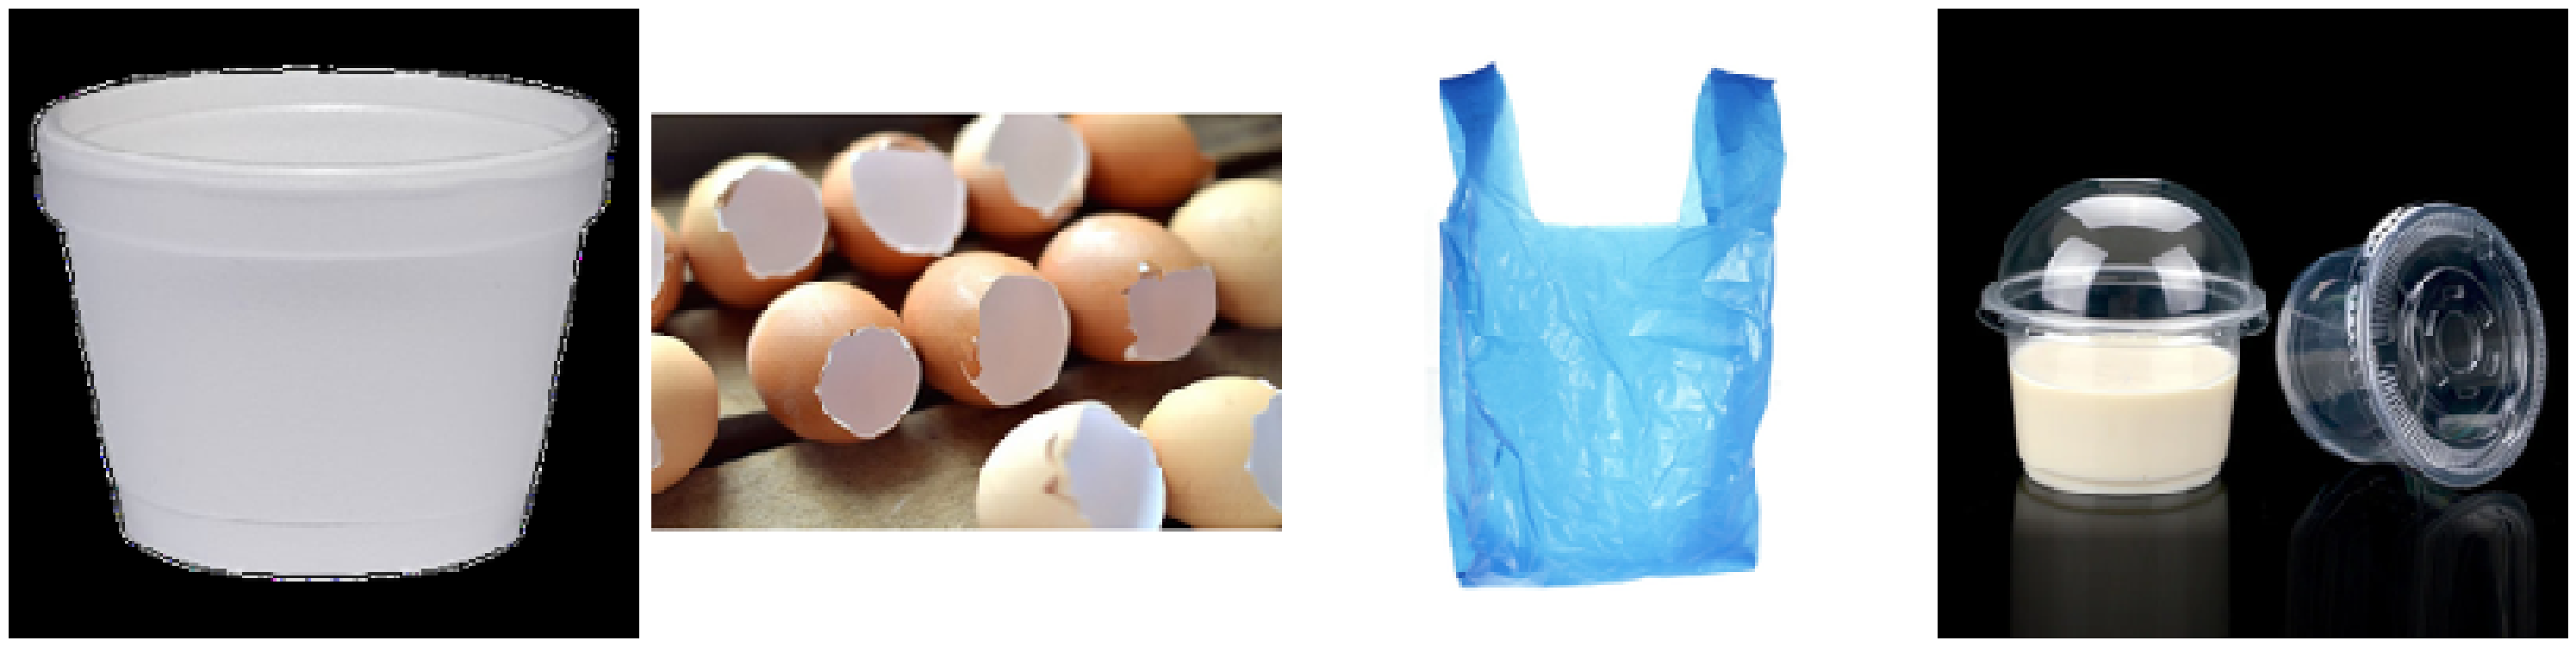

In [236]:
plotImages(sample_training_images[:8])

In [237]:
model=Sequential([
    Conv2D(filters=32,kernel_size=3,padding='same',activation='relu',input_shape=(224,224,3)),
    MaxPooling2D(pool_size=2),
    Conv2D(filters=64,kernel_size=3,padding='same',activation='relu'),
    MaxPooling2D(pool_size=2),
    Conv2D(filters=32,kernel_size=3,padding='same',activation='relu'),
    MaxPooling2D(pool_size=2),
    Conv2D(filters=32,kernel_size=3,padding='same',activation='relu'),
    MaxPooling2D(pool_size=2),
    Flatten(),
    Dense(7,activation='softmax')
])

#### **3.1.2** <font color=red> [5 marks] </font><br>
Train the model.

Use appropriate metrics and callbacks as needed.

In [240]:
# Training
batch_size=45
epochs=60
model.compile(optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │        43,911 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,015 (355.53 KB)

 Trainable params: 91,015 (355.53 KB)

 Non-trainable params: 0 (0.00 B)

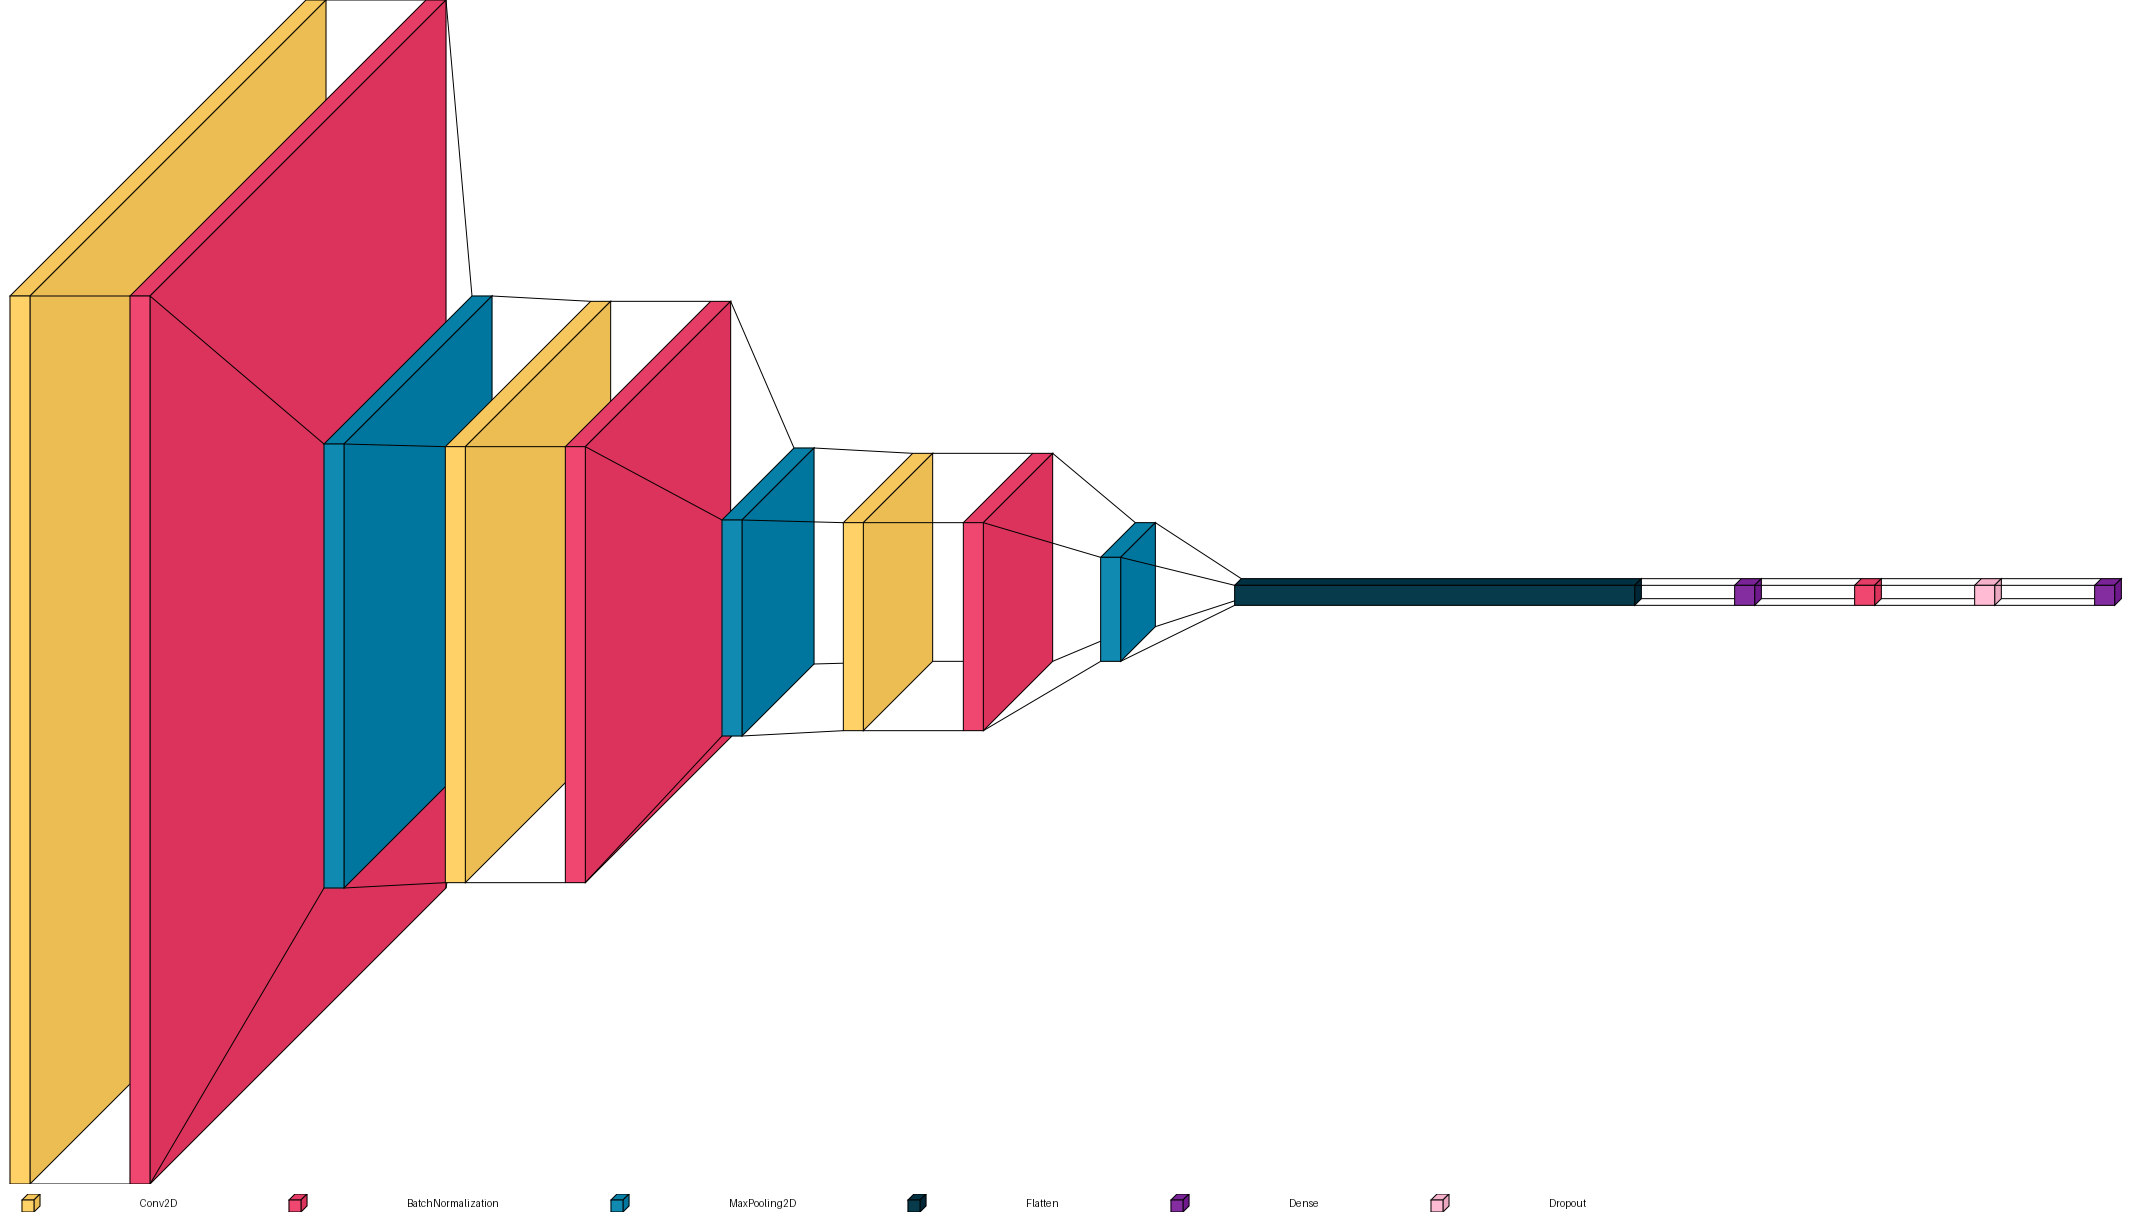

In [366]:
visualkeras.layered_view(model,legend=True,spacing=100)

### **3.2 Model Testing and Evaluation** <font color=red> [5 marks] </font><br>

#### **3.2.1** <font color=red> [5 marks] </font><br>
Evaluate the model on test dataset. Derive appropriate metrics.

In [244]:
# Evaluate on the test set; display suitable metrics
test_path=r"datasplit/test"
train_path=r"datasplit/train"
class_names=['cardboard','food_waste','glass','metal','other','paper','plastic']

In [245]:
img_cardboard=r"datasplit/test/cardboard"
gray_cardboard=r"datasplit/train/cardboard"
File_listing=os.listdir(img_cardboard)
for file in File_listing:
    im=Image.open(img_cardboard+'//'+file) 
    img=im.resize((32,32))
    gray=img.convert('L')
    gray.save(gray_cardboard+'//'+file,"png")

img_food_waste=r"datasplit/test/food_waste"
gray_food_waste=r"datasplit/train/food_waste"
File_listing=os.listdir(img_food_waste)
for file in File_listing:
    im=Image.open(img_food_waste+'//'+file) 
    img=im.resize((32,32))
    gray=img.convert('L')
    gray.save(gray_food_waste+'//'+file,"png")

img_glass=r"datasplit/test/glass"
gray_glass=r"datasplit/train/glass"
File_listing=os.listdir(img_glass)
for file in File_listing:
    im=Image.open(img_glass+'//'+file) 
    img=im.resize((32,32))
    gray=img.convert('L')
    gray.save(gray_glass+'//'+file,"png")

img_metal=r"datasplit/test/metal"
gray_metal=r"datasplit/train/metal"
File_listing=os.listdir(img_metal)
for file in File_listing:
    im=Image.open(img_metal+'//'+file) 
    img=im.resize((32,32))
    gray=img.convert('L')
    gray.save(gray_metal+'//'+file,"png")

img_other=r"datasplit/test/other"
gray_other=r"datasplit/train/other"
File_listing=os.listdir(img_other)
for file in File_listing:
    im=Image.open(img_other+'//'+file) 
    img=im.resize((32,32))
    gray=img.convert('L')
    gray.save(gray_other+'//'+file,"png")

img_paper=r"datasplit/test/paper"
gray_paper=r"datasplit/train/paper"
File_listing=os.listdir(img_paper)
for file in File_listing:
    im=Image.open(img_paper+'//'+file) 
    img=im.resize((32,32))
    gray=img.convert('L')
    gray.save(gray_paper+'//'+file,"png")

img_plastic=r"datasplit/test/plastic"
gray_plastic=r"datasplit/train/plastic"
File_listing=os.listdir(img_plastic)
for file in File_listing:
    im=Image.open(img_plastic+'//'+file) 
    img=im.resize((32,32))
    gray=img.convert('L')
    gray.save(gray_plastic+'//'+file,"png")

In [246]:
train_dir=os.path.join(train_path)
test_dir=os.path.join(test_path)

img_cardboard_dir=os.path.join(img_cardboard)
img_food_waste_dir=os.path.join(img_food_waste)
img_glass_dir=os.path.join(img_glass)
img_metal_dir=os.path.join(img_metal)
img_other_dir=os.path.join(img_other)
img_paper_dir=os.path.join(img_paper)
img_plastic_dir=os.path.join(img_plastic)

len(os.listdir(train_path))

7

In [247]:
num_cardboard_train=len(os.listdir(img_cardboard_dir))
num_food_waste_train=len(os.listdir(img_food_waste_dir))
num_glass_train=len(os.listdir(img_glass_dir))
num_metal_train=len(os.listdir(img_metal_dir))
num_other_train=len(os.listdir(img_other_dir))
num_paper_train=len(os.listdir(img_paper_dir))
num_plastic_train=len(os.listdir(img_plastic_dir))

num_cardboard_test=len(os.listdir(gray_cardboard))
num_food_waste_test=len(os.listdir(gray_food_waste))
num_glass_test=len(os.listdir(gray_glass))
num_metal_test=len(os.listdir(gray_metal))
num_other_test=len(os.listdir(gray_other))
num_paper_test=len(os.listdir(gray_paper))
num_plastic_test=len(os.listdir(gray_plastic))

train_sum=num_cardboard_train+num_food_waste_train+num_glass_train+num_metal_train+num_other_train+num_paper_train+num_plastic_train
test_sum=num_cardboard_test+num_food_waste_test+num_glass_test+num_metal_test+num_other_test+num_paper_test+num_plastic_test

In [248]:
test_loss,test_acc=model.evaluate(test_data_gen)
print('Test accuracy: {} Test Loss: {} '.format(test_acc*100,test_loss))

36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.1527 - loss: 1.9378
Test accuracy: 14.310646057128906 Test Loss: 1.9374363422393799 


In [249]:
train_dir='datasplit/train'
valid_dir='datasplit/valid'
test_dir='datasplit/test'

image_gen=ImageDataGenerator(rescale=1./255)
img_height=224
img_width=224
batch_size=32

In [250]:
train_data_gen=image_gen.flow_from_directory(
    train_dir,
    target_size=(img_height,img_width),
    batch_size=batch_size,
    class_mode='categorical'
)
valid_data_gen=image_gen.flow_from_directory(
    valid_dir,
    target_size=(img_height,img_width),
    batch_size=batch_size,
    class_mode='categorical'
)
test_data_gen=image_gen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 6483 images belonging to 7 classes.
Found 1142 images belonging to 7 classes.
Found 1146 images belonging to 7 classes.


In [251]:
steps_per_epoch=max(1,train_data_gen.samples//batch_size)
validation_steps=max(1,valid_data_gen.samples//batch_size)

In [252]:
loss,accuracy=model.evaluate(test_data_gen)
print(f"Test Accuracy:{accuracy:.2f}")

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.1397 - loss: 1.9440
Test Accuracy:0.14


In [253]:
#sample count, and class index
print("Train samples:",train_data_gen.samples)
print("Valid samples:",valid_data_gen.samples)
for cls, idx in train_data_gen.class_indices.items():
    print(f"Class: {cls}, Index: {idx}")

Train samples: 6483
Valid samples: 1142
Class: Cardboard, Index: 0
Class: Food_Waste, Index: 1
Class: Glass, Index: 2
Class: Metal, Index: 3
Class: Other, Index: 4
Class: Paper, Index: 5
Class: Plastic, Index: 6


In [368]:
#model compile with optimizer Adaptive moment estimation
model.compile(optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [255]:
#model training
history=model.fit(train_data_gen,
    validation_data=valid_data_gen,
    epochs=25,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            min_delta=0.01,
            restore_best_weights=True
        )
    ]
)

Epoch 1/25
203/203 ━━━━━━━━━━━━━━━━━━━━ 97s 475ms/step - accuracy: 0.3138 - loss: 1.7946 - val_accuracy: 0.3853 - val_loss: 1.6084
Epoch 2/25
203/203 ━━━━━━━━━━━━━━━━━━━━ 91s 449ms/step - accuracy: 0.4040 - loss: 1.5833 - val_accuracy: 0.4545 - val_loss: 1.4591
Epoch 3/25
203/203 ━━━━━━━━━━━━━━━━━━━━ 90s 441ms/step - accuracy: 0.4458 - loss: 1.4574 - val_accuracy: 0.4580 - val_loss: 1.4591
Epoch 4/25
203/203 ━━━━━━━━━━━━━━━━━━━━ 93s 459ms/step - accuracy: 0.5055 - loss: 1.3279 - val_accuracy: 0.4895 - val_loss: 1.3862
Epoch 5/25
203/203 ━━━━━━━━━━━━━━━━━━━━ 91s 446ms/step - accuracy: 0.5676 - loss: 1.1715 - val_accuracy: 0.5236 - val_loss: 1.4397
Epoch 6/25
203/203 ━━━━━━━━━━━━━━━━━━━━ 89s 437ms/step - accuracy: 0.6437 - loss: 0.9806 - val_accuracy: 0.5508 - val_loss: 1.3421
Epoch 7/25
203/203 ━━━━━━━━━━━━━━━━━━━━ 90s 444ms/step - accuracy: 0.7088 - loss: 0.8048 - val_accuracy: 0.5657 - val_loss: 1.3867
Epoch 8/25
203/203 ━━━━━━━━━━━━━━━━━━━━ 92s 451ms/step - accuracy: 0.7621 - loss: 0

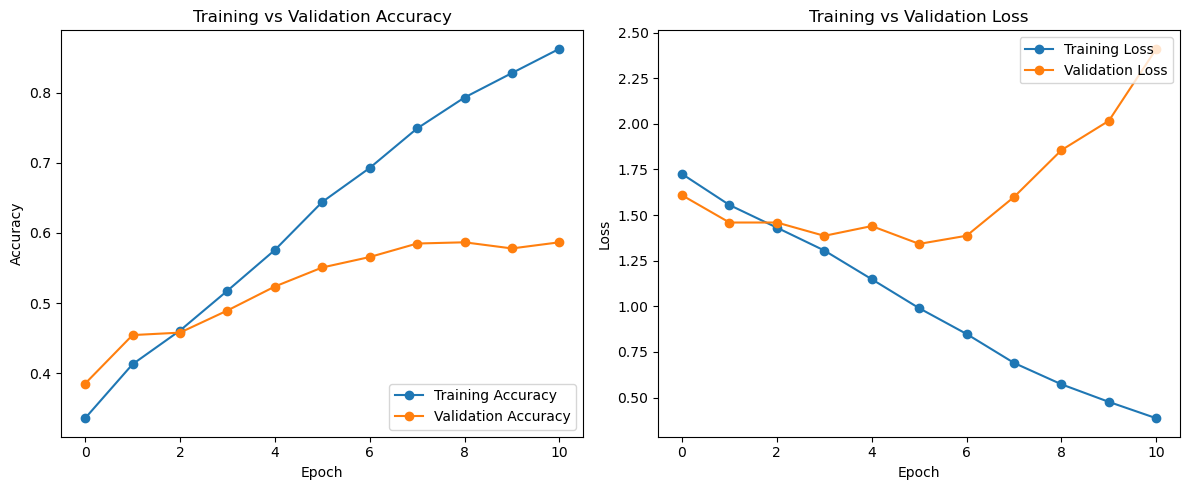

In [256]:
#history object metrics, epochs, plotting Accuracy and Loss
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range=range(len(acc))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Training Accuracy',marker='o')
plt.plot(epochs_range,val_acc,label='Validation Accuracy',marker='o')
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label='Training Loss',marker='o')
plt.plot(epochs_range,val_loss,label='Validation Loss',marker='o')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

In [257]:
#the Training and Validation accuracy and loss is not anywhere closer

In [258]:
#refining the model to prevent overfitting, augmentation, dropout, and learning rate
train_datagen=ImageDataGenerator(rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)
valid_datagen=ImageDataGenerator(rescale=1./255)
train_data_gen=train_datagen.flow_from_directory(
    'datasplit/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
valid_data_gen=valid_datagen.flow_from_directory(
    'datasplit/valid',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 6483 images belonging to 7 classes.
Found 1142 images belonging to 7 classes.


In [259]:
#cnn model with 3 convolution blocks 
model=Sequential([
    Conv2D(32,(3,3),activation='relu',input_shape=(224,224,3)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Conv2D(64,(3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Conv2D(128,(3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128,activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

In [370]:
#model compile with optimizer Adaptive moment estimation
model.compile(optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [372]:
#both the keras callbacks monitor the training process and auto-adjust based on the performance on validation data
early_stop=EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
reduce_lr=ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1
)

In [262]:
#model training
history=model.fit(
    train_data_gen,
    validation_data=valid_data_gen,
    epochs=25,
    batch_size=32,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/25
203/203 ━━━━━━━━━━━━━━━━━━━━ 454s 2s/step - accuracy: 0.2505 - loss: 2.4187 - val_accuracy: 0.1856 - val_loss: 2.0260 - learning_rate: 0.0010
Epoch 2/25
203/203 ━━━━━━━━━━━━━━━━━━━━ 891s 4s/step - accuracy: 0.3281 - loss: 1.8916 - val_accuracy: 0.3380 - val_loss: 1.7085 - learning_rate: 0.0010
Epoch 3/25
203/203 ━━━━━━━━━━━━━━━━━━━━ 452s 2s/step - accuracy: 0.3893 - loss: 1.6848 - val_accuracy: 0.4492 - val_loss: 1.5056 - learning_rate: 0.0010
Epoch 4/25
203/203 ━━━━━━━━━━━━━━━━━━━━ 224s 1s/step - accuracy: 0.4079 - loss: 1.5961 - val_accuracy: 0.4571 - val_loss: 1.5692 - learning_rate: 0.0010
Epoch 5/25
203/203 ━━━━━━━━━━━━━━━━━━━━ 1273s 6s/step - accuracy: 0.4357 - loss: 1.5297 - val_accuracy: 0.4895 - val_loss: 1.4213 - learning_rate: 0.0010
Epoch 6/25
203/203 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.4507 - loss: 1.4630 - val_accuracy: 0.4799 - val_loss: 1.4121 - learning_rate: 0.0010
Epoch 7/25
203/203 ━━━━━━━━━━━━━━━━━━━━ 1515s 7s/step - accuracy: 0.4590 - loss: 

In [263]:
#evaluation of validataion data and prediction
val_loss,val_acc=model.evaluate(valid_data_gen)
print(f"Validation Accuracy:{val_acc:.2f}")
preds=model.predict(valid_data_gen)
predicted_classes=preds.argmax(axis=1)

36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.6709 - loss: 0.9704
Validation Accuracy:0.67
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step


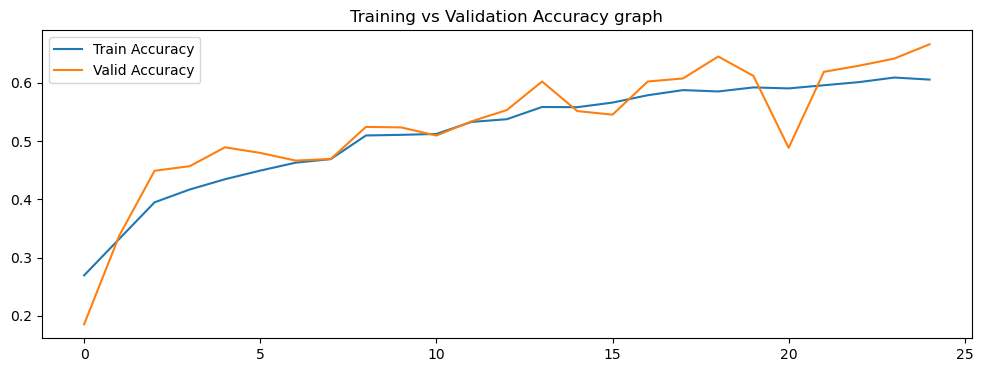

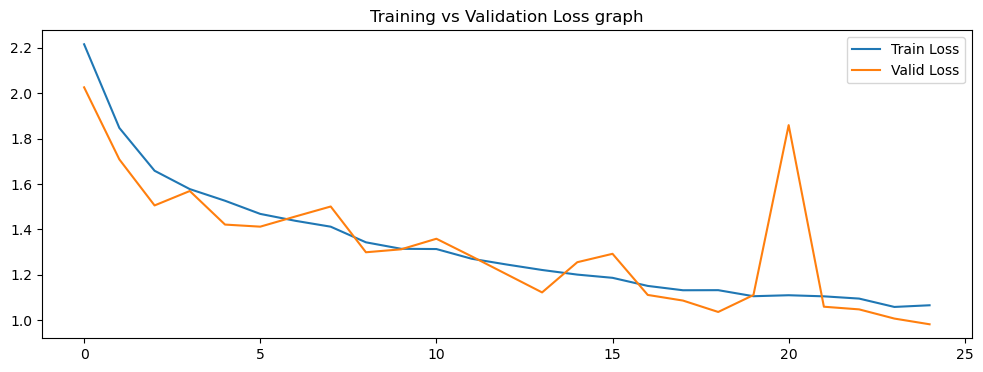

In [356]:
#plot the Training and validation accuracy and the loss graphs
plt.figure(figsize=(12,4))
plt.plot(history.history['accuracy'],label='Train Accuracy')
plt.plot(history.history['val_accuracy'],label='Valid Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy graph')
plt.show()
plt.figure(figsize=(12,4))
plt.plot(history.history['loss'],label='Train Loss')
plt.plot(history.history['val_loss'],label='Valid Loss')
plt.legend()
plt.title('Training vs Validation Loss graph')
plt.show()

In [265]:
#saving the model
model.save("waste_cnn_model.keras")

In [266]:
#truth labels, class labels and prediction
true_labels=valid_data_gen.classes
class_labels=list(valid_data_gen.class_indices.keys())
predictions=model.predict(valid_data_gen, verbose=1)
predicted_labels=np.argmax(predictions, axis=1)

36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step


In [267]:
#the classifiction report
print("Classification Report:\n")
print(classification_report(true_labels,predicted_labels,target_names=class_labels))

Classification Report:

              precision    recall  f1-score   support

   Cardboard       0.06      0.06      0.06        81
  Food_Waste       0.12      0.13      0.13       150
       Glass       0.05      0.04      0.05       112
       Metal       0.13      0.13      0.13       150
       Other       0.12      0.08      0.10       151
       Paper       0.16      0.18      0.17       154
     Plastic       0.29      0.32      0.31       344

    accuracy                           0.17      1142
   macro avg       0.13      0.14      0.13      1142
weighted avg       0.17      0.17      0.17      1142



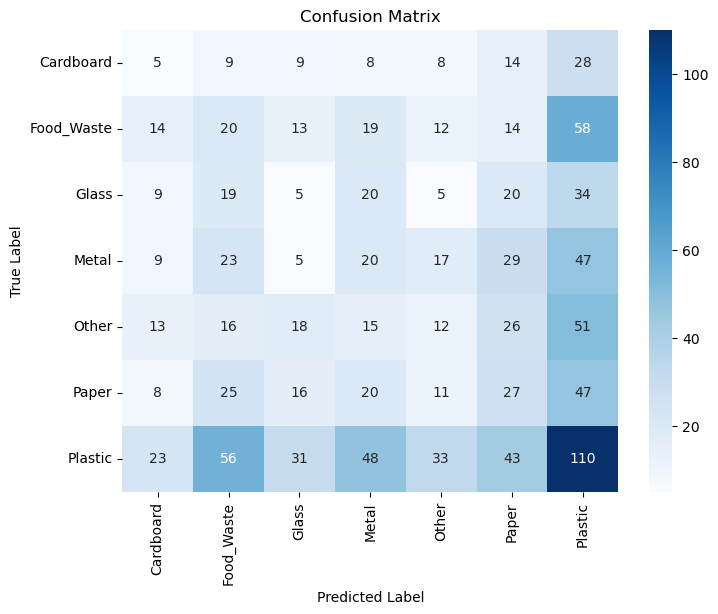

In [358]:
#confusion matrix
cm=confusion_matrix(true_labels,predicted_labels)
plt.figure(figsize=(8,6))
sns.heatmap(cm,annot=True,fmt="d",cmap="Blues",
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


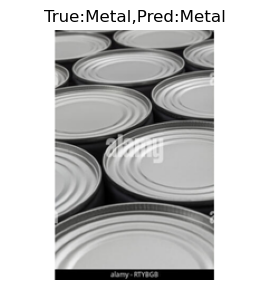

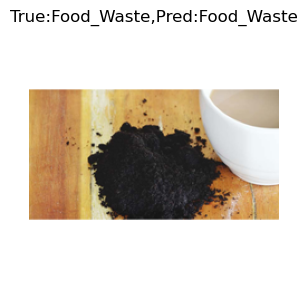

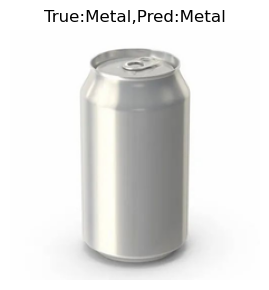

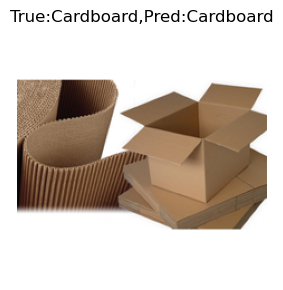

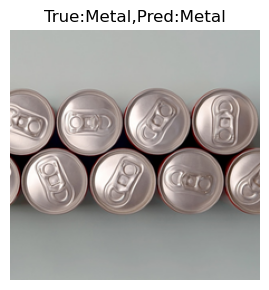

In [342]:
#show some images, and predictions from generator
x_batch,y_batch=next(valid_data_gen)
preds=model.predict(x_batch)
pred_classes=np.argmax(preds,axis=1)
true_classes=np.argmax(y_batch,axis=1)
for i in range(5):
    plt.figure(figsize=(3,3))
    plt.imshow(x_batch[i])
    plt.title(f"True:{class_labels[true_classes[i]]},Pred:{class_labels[pred_classes[i]]}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

## **4. Data Augmentation** <font color=red> [optional] </font><br>

#### **4.1 Create a Data Augmentation Pipeline**

##### **4.1.1**
Define augmentation steps for the datasets.

In [273]:
# Define augmentation steps to augment images
#the augmentation, dropout, and learning rate are done in the previous section, model training and evaluation 


Augment and resample the images.
In case of class imbalance, you can also perform adequate undersampling on the majority class and augment those images to ensure consistency in the input datasets for both classes.

Augment the images.

In [276]:
# Create a function to augment the images

In [277]:
# Create the augmented training dataset

##### **4.1.2**

Train the model on the new augmented dataset.

In [279]:
# Train the model using augmented images

## **5. Conclusions** <font color = red> [5 marks]</font>

#### **5.1 Conclude with outcomes and insights gained** <font color =red> [5 marks] </font>

#### Accuracy, Loss and Overfitting </font>

* Training accuracy improved
* Validation accuracy improved to 64%
* Learning rate reduced, smoothing training & avoiding overshooting
* Accuracies stayed close around 5%
* Overall, the epoch took 200s; it can be optimized with better hardware

#### Findings </font>
* Category Plastic has the best metrics, maybe due to more samples or features that is distinctive and stand out better in the training.
* There is model confusion between similar classes, like cardboard vs paper
* The performance is low due to data imbalance, category similarity, like paper vs cardboard
* The model would have improved with MobileNetV2, ResNet along with Batch Normalization, Dropouts, and Regularization, which is used here to reduce the overfitting.